In [1]:
import torch
import torch.nn.functional as F
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim

import copy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings

warnings.filterwarnings('ignore')

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

seed = 2050
torch.manual_seed(seed)
np.random.seed(seed)

cuda:0


## Generate and visualize the data distribution

In [3]:
# create some fake data
x1 = torch.rand(2000,1)*2-1
x2 = torch.rand(2000,1)*2-1
x3 = torch.rand(2000,1)*2-1
x4 = torch.rand(2000,1)*2-1

# 用x和y计算对应高度
def f1(x1,x2):
    return 3*np.sin((x1-x2)**2)
def f2(x1,x2):
    return (x1+x2)**3


y1=f1(x1,x2)
y2=f2(x3,x4)

data = torch.cat([x1,x2,x3,x4,y1,y2],dim=1)

In [4]:
train_data = data[:1000]
test_data = data[1000:]

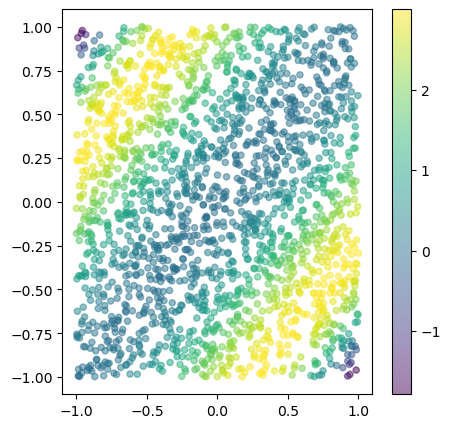

In [5]:
plt.figure(figsize=(5,5))
plt.scatter(x1,x2,s=20,c=y1,alpha=0.5)
plt.colorbar()
plt.show()

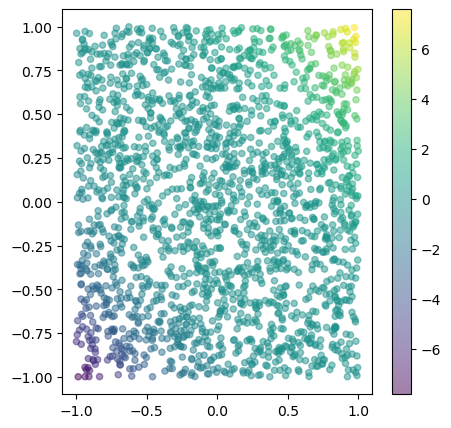

In [6]:
plt.figure(figsize=(5,5))
plt.scatter(x3,x4,s=20,c=y2,alpha=0.5)
plt.colorbar()
plt.show()

## Model definition

In [7]:
class PrunLinear(nn.Module):
    def __init__(self,inp_dim,out_dim,bias=True):
        super(PrunLinear, self).__init__()
        self.w = nn.Parameter(torch.randn(inp_dim,out_dim)*(2/(inp_dim)))
        self.b = nn.Parameter(torch.ones(out_dim)*(2/(inp_dim)))
        self.w_gate = nn.Parameter(torch.randn(inp_dim,out_dim,2)*(2/(inp_dim)))
        self.bias = bias
    def forward(self, x, gumbel=True):
        #x[N,inp]
        if gumbel:
            wg = F.gumbel_softmax(self.w_gate,dim=-1,tau=3,hard=True)[:,:,0]
        else:
            wg = torch.ones(self.w.shape).to(device)

        w = self.w*wg
        
        if self.bias:
            yhat = torch.matmul(x,w)+self.b
        else:
            yhat = torch.matmul(x,w)
        
        return yhat
    

class Predictor(nn.Module):
    """Simple NN with hidden layers [300, 100]

    Based on https://github.com/mi-lad/snip/blob/master/train.py
    by Milad Alizadeh.
    """
    def __init__(self, save_features=None, bench_model=False):
        super(Predictor, self).__init__()
        self.fc1 = PrunLinear(4, 10, bias=True)
        self.fc2 = PrunLinear(10, 10, bias=True)
        self.fc3 = PrunLinear(10, 2, bias=True)
        self.ac = nn.SiLU()
    def forward(self, x,gumbel=True):
        x1 = self.ac(self.fc1(x,gumbel))
        x2 = self.ac(self.fc2(x1,gumbel))
        x3 = self.fc3(x2,gumbel)
        return x3

In [8]:
seed = 2050
torch.manual_seed(seed)
np.random.seed(seed)
# define the model, loss function and optimizer
model = Predictor().to(device)
lossfn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [9]:
# record the loss and density
lss = []
lss_test = []
dens = []

In [10]:
ifgum = True
target_per = 0.
for epoch in tqdm(range(7500)):
    
    # train
    train_loss = 0
    x,y = train_data[:,:4].to(device),train_data[:,4:].to(device)
        
    yhat = model(x,ifgum)
    loss = torch.mean(torch.abs(yhat-y))

    m1edges = F.gumbel_softmax(model.fc1.w_gate,dim=-1,hard=True)[:,:,0].view(-1)
    m2edges = F.gumbel_softmax(model.fc2.w_gate,dim=-1,hard=True)[:,:,0].view(-1)
    m3edges = F.gumbel_softmax(model.fc3.w_gate,dim=-1,hard=True)[:,:,0].view(-1)
    model_edges = [m1edges,m2edges,m3edges]
    sp_ls = torch.abs(target_per-torch.mean(torch.cat(model_edges)))


    floss = loss+sp_ls*0.01
    optimizer.zero_grad()
    floss.backward()
    optimizer.step()
    
    
    if epoch% 10 == 0:
        lss.append(loss.item())
        dens.append(torch.mean(torch.cat(model_edges)).item())
    
    # test
    if epoch% 50 == 0:
        with torch.no_grad():
            x,y = test_data[:,:4].to(device),test_data[:,4:].to(device)
            yhat = model(x,ifgum)
            loss = lossfn(yhat,y)
            lss_test.append(loss.item())

100%|██████████| 7500/7500 [01:10<00:00, 106.15it/s]


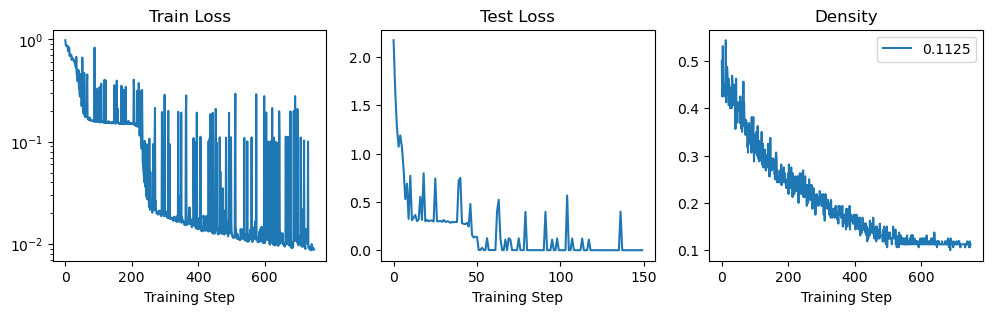

In [11]:
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title('Train Loss')
plt.xlabel('Training Step')
plt.plot(lss)
plt.yscale('log')
plt.subplot(132)
plt.plot(lss_test)
plt.title('Test Loss')
plt.xlabel('Training Step')
plt.subplot(133)
plt.plot(dens,label=str(round(dens[-1],5)))
plt.title('Density')
plt.xlabel('Training Step')
plt.legend()
plt.show()

## Exchange the neurons for a better visualization

In [12]:
def exchange(mat_a,mat_b,i,j):
    mat1 = copy.deepcopy(mat_a)
    mat2 = copy.deepcopy(mat_b)
    
    t = copy.deepcopy(mat1[:,i])
    mat1[:,i] = mat1[:,j]
    mat1[:,j] = t
    
    t = copy.deepcopy(mat2[i,:])
    mat2[i,:] = mat2[j,:]
    mat2[j,:] = t
    return mat1,mat2


In [13]:
wg1 = 1-torch.argmax(model.fc1.w_gate,dim=-1).cpu().detach().numpy()
wg2 = 1-torch.argmax(model.fc2.w_gate,dim=-1).cpu().detach().numpy()
wg3 = 1-torch.argmax(model.fc3.w_gate,dim=-1).cpu().detach().numpy()

In [14]:
ex_seq01 = [
    [3,8],
    [3,9],
    [0,7],
    [6,8]
]
ex_seq12 = [
    [2,9],
    [4,6],
]

In [15]:
w1_c = copy.deepcopy(model.fc1.w.cpu().detach().numpy())
w2_c = copy.deepcopy(model.fc2.w.cpu().detach().numpy())
w3_c = copy.deepcopy(model.fc3.w.cpu().detach().numpy())
wg1_c = copy.deepcopy(wg1)
wg2_c = copy.deepcopy(wg2)
wg3_c = copy.deepcopy(wg3)


In [16]:
for ex in ex_seq01:
    w1_c,w2_c = exchange(w1_c,w2_c,ex[0],ex[1])
    wg1_c,wg2_c = exchange(wg1_c,wg2_c,ex[0],ex[1])
for ex in ex_seq12:
    w2_c,w3_c = exchange(w2_c,w3_c,ex[0],ex[1])
    wg2_c,wg3_c = exchange(wg2_c,wg3_c,ex[0],ex[1])

In [17]:
min_val = min(np.min(w1_c*wg1_c),np.min(wg2_c*w2_c),np.min(wg3_c*w3_c))
max_val = max(np.max(w1_c*wg1_c),np.max(wg2_c*w2_c),np.max(wg3_c*w3_c))

cmap = plt.cm.seismic
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)

def get_color(value):
    return cmap(norm(value))

## Plotting

In [18]:
def plot_neural_network(adj1, adj2, adj3, w1, w2, w3):
    fig, ax = plt.subplots(figsize=(4, 5),dpi=150)
    
    bgc = 'k'
    
    # 定义三层的位置
    input_x, hidden_x1, hidden_x2, output_x = 0.1, 0.3,0.5,0.7
    input_y = np.linspace(0.3, 0.7, adj1.shape[0])
    hidden_y1 = np.linspace(0.2, 0.8, 10)
    hidden_y2 = np.linspace(0.2, 0.8, 10)
    if adj3.shape[1] == 1:
        output_y = [0.5]
    elif adj3.shape[1] == 2:
        output_y = [0.333, 0.666]
    elif adj3.shape[1] == 3:
        output_y = np.linspace(0.3, 0.7, 3)
    # 画输入层
    dotsz = 30
    for idx,y in enumerate(input_y):
        ax.scatter(y, input_x, s=dotsz, color=bgc, zorder=3)
    
    
    # 画隐含层
    for y in hidden_y1:
        ax.scatter(y,hidden_x1, s=dotsz, color=bgc, zorder=3)
    for y in hidden_y2:
        ax.scatter(y,hidden_x2, s=dotsz, color=bgc, zorder=3)
    
    # 画输出层
    for y in output_y:
        ax.scatter( y,output_x, s=dotsz, color=bgc, zorder=3)


    # 画连接线
    for i, row in enumerate(adj1):
        for j, val in enumerate(row):
            if val == 1:
                ax.plot( [input_y[i], hidden_y1[j]], [input_x, hidden_x1],'k-', lw=1.5,color=get_color(w1[i,j]),alpha=0.8)
    
    for i, row in enumerate(adj2):
        for j, val in enumerate(row):
            if val == 1:
                ax.plot([hidden_y1[i], hidden_y2[j]], [hidden_x1, hidden_x2], 'k-', lw=1.5,color=get_color(w2[i,j]),alpha=0.8)
    
    
    for i, row in enumerate(adj3):
        for j, val in enumerate(row):
            if val == 1:
                ax.plot( [hidden_y2[i], output_y[j]],[hidden_x2, output_x], 'k-', lw=1.5,color=get_color(w3[i,j]),alpha=0.8)
    
    ax.axis('off')
    plt.show()

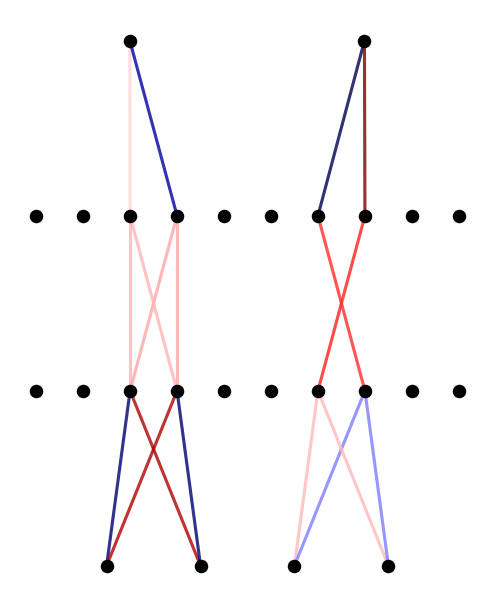

In [19]:
plot_neural_network(wg1_c, wg2_c, wg3_c, w1_c,w2_c,w3_c)